In [ ]:
import numpy as np
from mtalg.random import MultithreadedRNG
import pickle
from tqdm import tqdm
import scipy
import cupy as cp
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import multivariate_t
import Other_Mean_Algs as OMA
import PD_Median_Functions_opt_for_sims

viridis = cm.get_cmap('viridis', 8)

C:\Users\12RAM\AppData\Local\Temp\ipykernel_21520\1585302523.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 8)


In [ ]:
########### Generate the datasets, unit vectors for the PD median
# ##  and starting values for the MCMC/GD and save in folders
########## This is useful for reproducibility and makes the code slightly faster
#Number of runs in the experiment
num_runs=50
# maximum dimension analysed
d=20
# sample size
ndata=50000


##### First generate the datasets and pickle them #####

# This allows us to set the seed with the mtalg package
mrng = MultithreadedRNG(seed=421, num_threads=10)

#generate the data and write to files
for run in tqdm(range(num_runs)):
    mean = np.full(d,0)    # location
    cov = np.identity(d)  # scale matrix
    data_clean=multivariate_t.rvs(loc=mean, shape=cov, df=1, size=ndata, random_state=421)
    #now pickle it for reloading later
    #pickle 1
    fn="data/data_set_clean_"+str(run)+"_3.pickle"
    with open(fn,"wb") as file:
        pickle.dump(data_clean,file)


# Already done in other files, run this if you are only running this file 0
# ##### Second generate the unit vectors to be used ##### 
# #number of unit vectors
# nvec=20000
# #dimensions in the experiment
dimensions=[2,10,20]

# # This allows us to set the seed with the mtalg package
# mrng = MultithreadedRNG(seed=422, num_threads=10)
# # Generate unit vectors and save them for later
# for d in tqdm(dimensions):
#     for run in range(num_runs):
#         unit_vectors=mrng.standard_normal(size=(nvec,d))
#         for i in range(0,nvec):
#             unit_vectors[i,:]=unit_vectors[i,:]/np.linalg.norm(unit_vectors[i,:])
#     #now pickle it for reloading
#         fn="unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run)+".pickle"
#         with open(fn,"wb") as file:
#             pickle.dump(unit_vectors,file)



# Third generate the starting values for langevin and gradient descent #### 

mrng = MultithreadedRNG(seed=423, num_threads=10)
#generate uv and save them for later
for d in tqdm(dimensions):
    for run in range(num_runs):
        start=mrng.standard_normal(size=d)+np.full(d,5)
    #now pickle it for reloading
        fn="starting/starting_dimension_"+str(d)+"_run_"+str(run)+"_3.pickle"
        with open(fn,"wb") as file:
            pickle.dump(start,file)




100%|██████████| 3/3 [00:00<00:00, 11.60it/s]


In [ ]:
####################################################################
###################### Functions for s-IDD median #########################
####################################################################
# This is the expit or sigmoid function with smoothing parameter "smooth" (1+exp(-smooth*x))^{-1}
def expit(x,smooth):
    return scipy.special.expit(x*smooth)

# Computes the smoothed integrated dual depth
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# n: integer sample size
def idd_beta(x,smooth,pj_data,u,n):
    # pj_data=np.matmul(data,u)
    pj_x=np.matmul(u,x)
    # Now for each u find univariate depth and average, u are the columns
    depth= expit(pj_x-pj_data,smooth)
    depth= np.sum(depth,0)/n
    depth= depth*(1-depth)
    depth= np.mean(depth)
    return depth


# Computes the gradient of the smoothed integrated dual depth
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# m: integer number of unit vectors sampled
# n: integer sample size
def grad_depth(x,pj_data,u,smooth,n,m):
    x=cp.asarray(x)
    # pj_data=np.matmul(data,u)
    # pj data is n  x m
    # pj x is m x 1
    # x is d x 1
    # u m x d
    pj_x=cp.matmul(u,x)
    #expits is n x m 
    expits=expit(pj_x-pj_data,smooth)  
    term1= expits*(1-expits)
    # sum/mean along the columns now
    term1=cp.sum(term1,0)/n
    term2=1-2*cp.sum(expits,0)/n
    ddx=term1*term2*smooth
    # Now ddx is "1 x m" but is a vector
    # multiply each column of u by ddx 
    grad=(u.T)*ddx
    grad=cp.sum(grad,1)/m
    # final=n*eps* uv/2
    return cp.asnumpy(grad)


#Gradient of the log density of a normal prior 
# x: d x 1 numpy array for point at which depth is computed
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
def grad_prior(x,prior_mean,prior_cov_inv):
    return -np.matmul(x-prior_mean,prior_cov_inv)


# Gradient descent algorithm for computing the non-private smoothed IDD median 
# x: d x 1 numpy array for point at which depth is computed
# u: m x d numpy array of uniformly sampled unit vectors
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# m: integer number of unit vectors sampled
# n: integer sample size
# eps: pure privacy parameter
def GD_update(x,step,d,pj_data,smooth,n,m,unit_vectors):
    return x+step*(grad_depth(x,pj_data,unit_vectors,smooth,n,m))

######
### one step of langevin dynamics
## 
# x: d x 1 numpy array for point at which depth is computed
# step: step size for the langevin dynamics
# sqrt2step: just sqrt(2*step)
# d: integer dimension
# pj_data: n  x m numpy array of projections of data onto u
# smooth: float, value of the smoothing parameter "s"
# n: integer sample size
# m: integer number of unit vectors sampled
# unit_vectors: m x d numpy array of uniformly sampled unit vectors
# eps: pure privacy parameter
# prior_mean: d x 1 numpy array representing the prior mean
# prior_cov_inv: d x d numpy array representing the inverse of the prior covariance matrix
# mrng: this is the seed for the mtalg package
def langevin_update(x,step,sqrt2step,d,pj_data,smooth,n,m,unit_vectors,eps,prior_mean,prior_cov_inv,mrng):
    prior_grad=grad_prior(x,prior_mean,prior_cov_inv)
    depth_grad=grad_depth(x,pj_data,unit_vectors,smooth,n,m)
    # beta=eps*n/6 ensures eps-DP for smoothed IDD 
    return x+step*(prior_grad+depth_grad*eps*n/6)+sqrt2step*mrng.standard_normal(size=d)

####################################################################

In [ ]:

# This function returns one run of the simulation experiment for a given run_number
# OUTPUT:
# x_p:  the Markov chain for the private median 
# x_np: the iterations of the gradient descent for the non-private median 
# x:  the Markov chain for the private s median 
# x2: the iterations of the gradient descent for the non-private s median 
# cp: coin-press mean 
# INPUT: 
# run_number: the number from 1-50 corresponding to the simulation run
# fn_dict: functions to compute values associated with the type of pd median for faster simulation, see example below
# d: integer dimension
# tau: tau parameter for priv pd median
# eta: eta parameter for priv pd median
# eps: privacy parameter
# rho: rho for coinpress
# delta: delta privacy parameter
# nvec: integer number of unit vectors sampled
# ndata: integer sample size
# step: step size for the langevin dynamics
# sqrt2step: just sqrt(2*step)
# n_steps_gd: Number of iterations in the gradient descent for the non-private median
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private medians
# step_l: step size for the langevin dynamics for the private medians
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation, this is clean for the heavy tail scenario

def experiment(run_number,fn_dict,d,tau,eta,eps,rho,delta,nvec,n_steps_gd,n_steps_mc,step_g,step_l,data_type='clean',ndata=100):
    # set the seed for the langevin dynamics to be the run number
    # this way we can reproduce the chain 
    # only use 1 thread because we are on the gpu
    mrng = MultithreadedRNG(seed=run_number, num_threads=1)
    
    ####################################################################
    # load in data, unit vectors and starting value
    with open("data/data_set_"+data_type+"_"+str(run_number)+"_3.pickle",'rb') as file:
        data=pickle.load(file)
    data=data[0:ndata,0:d]
    
    ####################################################################
    with open("unit_vectors/unit_vectors_dimension_"+str(d)+"_run_"+str(run_number)+".pickle",'rb') as file:
        unit_vectors=pickle.load(file)
    unit_vectors=unit_vectors[0:nvec,:]
    
    ####################################################################
    with open("starting/starting_dimension_"+str(d)+"_run_"+str(run_number)+"_3.pickle",'rb') as file:
        x0=pickle.load(file)
    
    # Make torch for coinpress
    X=torch.tensor(data).float()


    # move data to GPU
    data=cp.asarray(data)
    x00=x0.copy()
    x0=cp.asarray(x0)
    unit_vectors=cp.asarray(unit_vectors)

    ######################### PD Medians ###########################################
    IV=PD_Median_Functions_opt_for_sims.get_initial_values(unit_vectors,data,fn_dict['mu'],fn_dict['sigma'])
    ###### MCMC-lagevin dyanmics for private median
    x_p=PD_Median_Functions_opt_for_sims.compute_PTR_PD_Median(data,fn_dict,tau,eta,eps,delta,IV=IV,
                            nvec=unit_vectors.shape[0],mrng=mrng,step_l=step_l,nstep=n_steps_mc,u=unit_vectors,x0=x0,return_chain=True,joint=True)
    
    ###### Gradient Descent for non-private median
    x_np=PD_Median_Functions_opt_for_sims.non_private_pd(IV,unit_vectors,d,step_g,nstep=n_steps_gd,plot=False,x0=x0,return_chain=True)
    
    ######################### s-IDD Medians ###########################################
    ## Let's do IDD Median
    # Smooth param
    smooth=10
    # compute the projections of the data onto the randomly drawn unit vectors
    pj_data=np.matmul(unit_vectors,data.T).T
    # move projections and unit vectors to GPU, you must have an Nvidia gpu with cuda installed
    pj_data=cp.asarray(pj_data)
    unit_vectors=cp.asarray(unit_vectors)
    
    ###### MCMC-lagevin dyanmics for private median
    prior_mean=np.zeros(d)
    prior_cov_inv=np.eye(d)/25*np.sqrt(d)
    x = []
    x.append(x00)
    sqrt2step = np.sqrt(2*step_l)
    for t in range(n_steps_mc):
        x.append(langevin_update(x[-1],step_l,sqrt2step,d,pj_data,smooth,ndata,nvec,unit_vectors,eps,prior_mean,prior_cov_inv,mrng))
    
    ###### Gradient Descent for non-private median
    x2= []
    x2.append(x00)
    # np.random.normal(0,1,d))
    for t in range(n_steps_gd+200):
        x2.append(GD_update(x2[-1],step_g*400,d,pj_data,smooth,ndata,nvec,unit_vectors))


    ## Let's do Coinpress too
    
    cp_mean= OMA.COINPRESS(X,ndata,d,rho,torch.full((1,d),0),10000,10000)[0]
    return x_p,x_np,x,x2,cp_mean


In [ ]:

# This function plots and saves the results from each experiment. 
# It writes the progression of the GD and MCMC to text files, the mean to a text file
# It plots the chains over time 
# INPUT: 
# results: list of results from 50 runs of the simulations
# d: integer dimension
# n_steps_gd: Number of iterations in the gradient descent for the non-private median
# n_steps_mc:Number of iterations in the langevin dynamics for the private median
# step_g: step size for the gradient descent for the non-private median
# step_l: step size for the langevin dynamics for the private median
# data_type: either 'clean' for the uncontaminated simulation or 'con' for the contaminated simulation, clean for heavy
def plot_and_save(results,d,n_steps_gd,n_steps_mc,data_type='clean',tag='unsp'):
    pr_est=np.zeros(d)
    np_est=np.zeros(d)
    colors= viridis(range(8))
    count=0
    for i in results:
        x_p,x_np,x,x2,x_cp = i
        ## PD Median
        #pr
        x_p = [xx.get() for xx in x_p]
        x_p = np.vstack(x_p)
        # print(x_p.shape)
        norm_x_p = np.linalg.norm(x_p,axis=1)
        # print(np.vstack(x_p).shape)
        # pr_est=np.vstack([pr_est,x_p[n_steps_mc-1,:]])
        pr_est=x_p[-1,:]
        ##np
        x_np = [xx.get() for xx in x_np]
        x_np = np.vstack(x_np)
        norm_x_np = np.linalg.norm(x_np,axis=1)
        # print(norm_x_np.shape)
        np_est=x_np[-1,:]

        # S-IDD
        x = [xx for xx in x]
        x = np.vstack(x)
        # print(x_p.shape)
        norm_x = np.linalg.norm(x,axis=1)
        # print(np.vstack(x_p).shape)
        # pr_est=np.vstack([pr_est,x_p[n_steps_mc-1,:]])
        pr_idd_est=x[-1,:]
        ##np
        x2 = [xx for xx in x2]
        x2 = np.vstack(x2)
        norm_x2 = np.linalg.norm(x2,axis=1)
        # print(norm_x_np.shape)
        np_idd_est=x2[-1,:]

        if count==0:
            plt.plot(np.arange(n_steps_mc+1),norm_x_p,color=colors[0],label=r'private pd median')
            plt.plot(np.arange(n_steps_gd+1),norm_x_np,color=colors[4],label=r'non-private pd median')
            plt.ylabel('estimate norm', fontsize=18)
            plt.xlabel('time step', fontsize=18)
            plt.legend(fontsize=18)
        else:
            plt.plot(np.arange(n_steps_mc+1),norm_x_p,color=colors[0])
            plt.plot(np.arange(n_steps_gd+1),norm_x_np,color=colors[4])
        plt.plot(np.arange(n_steps_mc+1),norm_x,color=colors[3])
        plt.plot(np.arange(n_steps_gd+1+200),norm_x2,color=colors[6])
        count=count+1
    # plt.show()
    #save the plot
    fname='out_img/'+tag+'_pd_dimension_'+str(d)+"_"+data_type+"_gaussian_med_eps_heavy_med_eps_heavy.png"
    plt.savefig(fname,dpi=600)
    plt.show()
    ##### save the estimates to a csv
     ## private pdd
    fn_p="output/"+tag+"_private_pd_results_dimension_"+str(d)+"_"+data_type+"_gaussian_med_eps_heavy.csv"
    fn_p=open(fn_p, 'w', newline='')
    np.savetxt(fn_p, pr_est, delimiter=",")   
    fn_p.close()
     ## non p 
    fn_np="output/"+tag+"non_private_pd_results_dimension_"+str(d)+"_"+data_type+"_gaussian_med_eps_heavy.csv"
    fn_np=open(fn_np, 'w', newline='')
    np.savetxt(fn_np, np_est, delimiter=",")
    fn_np.close()
    ## sIDD p
    fn_p="output/"+tag+"_private_sidd_results_dimension_"+str(d)+"_"+data_type+"_gaussian_med_eps_heavy.csv"
    fn_p=open(fn_p, 'w', newline='')
    np.savetxt(fn_p, pr_idd_est, delimiter=",")   
    fn_p.close()
    ## sIDD nonp
    fn_np="output/"+tag+"non_private_sidd_results_dimension_"+str(d)+"_"+data_type+"_gaussian_med_eps_heavy.csv"
    fn_np=open(fn_np, 'w', newline='')
    np.savetxt(fn_np, np_idd_est, delimiter=",")
    fn_np.close()
    ## CP
    fn_cp="output/"+tag+"cp_results_dimension_"+str(d)+"_"+data_type+"_gaussian_med_eps_heavy.csv"
    fn_cp=open(fn_cp, 'w', newline='')
    np.savetxt(fn_cp, x_cp, delimiter=",")
    fn_cp.close()


In [182]:
# experiment parameters

num_runs=int(50)
# num_runs=int(2)
ndata=50000
nvecs=[500,500,1000,2500,2500]
nsteps_gd=[1000,2000,4000,1000,1000]
# nsteps_gd=[100,100,100]
nsteps_mc=[1000,2000,4000,3000,5000]
# nsteps_mc=[100,100,100]
gd=0.025
gd_step_sizes=[gd,gd,gd,gd,gd]
mc=0.00015
taus=[]
mc_step_sizes=[mc,mc,mc,mc,mc]
dimensions=[2,10,20]


starting dimension 2


100%|██████████| 50/50 [1:06:29<00:00, 79.79s/it]


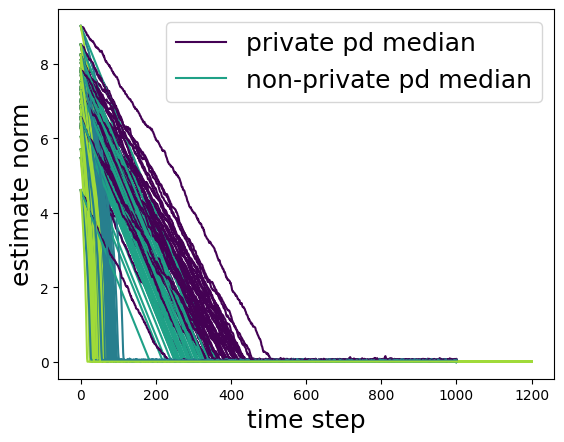

starting dimension 10


100%|██████████| 50/50 [1:36:03<00:00, 115.27s/it]


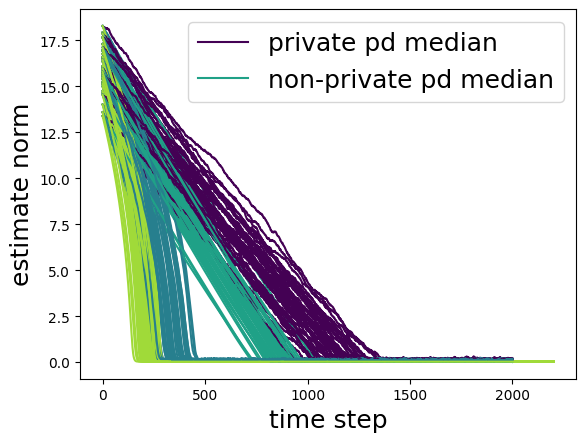

starting dimension 20


100%|██████████| 50/50 [4:50:33<00:00, 348.68s/it]  


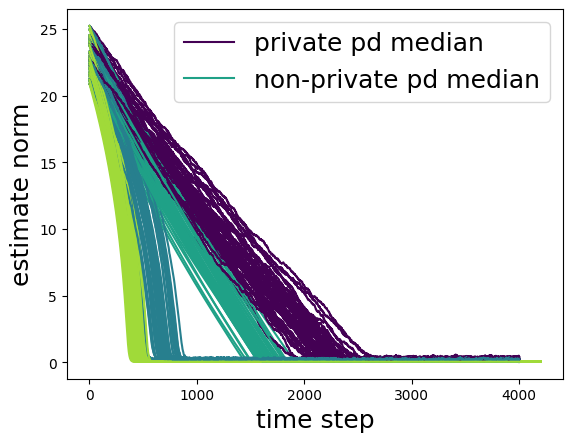

In [ ]:
# Used as inpute into experiment, these functions compute various quantities associated with the location and scale chosen, see manuscript
fn_dict_med_mad={
     'mu': PD_Median_Functions_opt_for_sims.med,
     'sigma': PD_Median_Functions_opt_for_sims.mad,
     'Smu': PD_Median_Functions_opt_for_sims.S_med,
     'Ssigma': PD_Median_Functions_opt_for_sims.S_mad,
     'bhat': PD_Median_Functions_opt_for_sims.b_hat_mad,
     'joint': PD_Median_Functions_opt_for_sims.S_med_mad_b_joint,
     'mad_flag': True
}

tau=5
eta=0.01
eps=5
rho=0.666457
# https://desfontain.es/blog/converters-differential-privacy.html
# Simplified wrapper for the experiment function for the clean experiment
def m_experiment(run_number,d,gd_step, mc_step_size ,nstep_gd,nstep_mc,nvec):
    x_p,x_np,x,x2,x_cp=experiment(run_number,fn_dict_med_mad,d,tau,eta,eps,rho,10/ndata,nvec,nstep_gd,nstep_mc,gd_step,mc_step_size,data_type='clean',ndata=ndata)
    return x_p,x_np,x,x2,x_cp


# run the experiment for the clean data
for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    gd_step_size=gd_step_sizes[i]
    mc_step_size=mc_step_sizes[i]
    nstep_gd=nsteps_gd[i]
    nstep_mc=nsteps_mc[i]
    nvec=nvecs[i]
    results=[]
    for j in tqdm(range(num_runs)):
        result_j=m_experiment(j,d,gd_step_size, mc_step_size,nstep_gd,nstep_mc,nvec)
        if result_j[0]=="Test failed":
            print(j, ' failed')
            # break
        else:
            results.append(result_j)
    plot_and_save(results,d,nstep_gd,nstep_mc,data_type='clean',tag='med_mad')
        # #save the chains too in case we want to modify the graphs
    fn="output/delta_med_mad_results_clean_dimension_"+str(d)+"_med_eps_heavy.pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)



In [ ]:
dimensions=[2,10,20]

# This function returns one run of the simulation experiment for a given run_number for the sample mean (nonprivate )
def experiment_sm(run_number,d,ndata=10000):
    # set the seed for the langevin dynamics to be the run number
    # this way we can reproduce the chain 
    # only use 1 thread because we are on the gpu
    mrng = MultithreadedRNG(seed=run_number, num_threads=1)
    ####################################################################
    # load in data, unit vectors and starting value
    with open("data/data_set_clean_"+str(run_number)+"_3.pickle",'rb') as file:
        data=pickle.load(file)
    data=data[0:ndata,0:d]
    
    ####################################################################
    sm=np.mean(data,axis=0)
    return sm

for i in range(len(dimensions)):
    d=dimensions[i]
    print('starting dimension '+str(d))
    results=[]
    for j in tqdm(range(num_runs)):
        result_j=experiment_sm(j,d,ndata=10000)
        results.append(result_j)
        # #save the chains too in case we want to modify the graphs
    fn="output/sm_results_heavy_dimension_"+str(d)+".pickle"
    with open(fn,"wb") as file:
        pickle.dump(results,file)

starting dimension 2


100%|██████████| 50/50 [00:00<00:00, 114.01it/s]


starting dimension 10


100%|██████████| 50/50 [00:00<00:00, 397.34it/s]


starting dimension 20


100%|██████████| 50/50 [00:00<00:00, 392.11it/s]
